## Multi-messenger observations of binary neutron star mergers in the O4 run

### Introduction

In this notebook I will present the necessary scripts to represent the main figures of the paper [_"Multi-messenger observations of binary neutron star mergers in the O4 run"_](https://arxiv.org/abs/2204.07592). If you have any questions or if you find any mistakes, please contact me at a.colombo140@campus.unimib.it.

### Loading our NSNS population

Our NSNS population properties (mass, deformability, redshift ecc.) and EM counterparts (kilonova, GRB prompt and afterglow) are contained in a HDF5 file. We generated $10^6$ binaries with a uniform distribution for the component masses $m_1$ and $m_2$ (between 1 and 2.06 $M_\odot$), for the viewing angle $\theta_v$
(between 0 and $\pi /2$) and with a log-normal distribution for the redshift $z$ (between 0.005 and 4). For each binary we computed (assuming the SFHo equation of state):
* the SNR in the LIGO, Virgo and KAGRA detectors with the projected O4 sensitivities;
* the kilonova light curve from 0.1 to 50 days in the $g$, $z$ and $J$ band;
* the GRB afterglow light curve from 0.1 to 1000 days in the radio, optical and X band;
* the GRB prompt photon flux in the 10-1000 keV (_Fermi_/GBM) and 15-150 keV (_Swif_/BAT) energy band.

For further information on our model, please take a look at section 2.2 of the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

num = 1000000 #number of binaris
eos = "SFHo" #equation of state
mns_max = 2.058882 #maximum mass assuming the SFHo EoS

table = h5py.File('./nsns_%i_%s.hdf5' %(num,eos),'r') #the HDF5 file containing our population

print("Loading intrinsic population")
m1 = table['m1'][()] #mass of the primary component
m2 = table['m2'][()] #mass of the secondary component
lamb1 = table['lamb1'][()] #deformability of the primary component
lamb2 = table['lamb2'][()] #deformability of the secondary component
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()] #RA
dec = table['dec'][()] #DEC
pol = table['pol'][()] #polarization angle
m_dyn = table['m_dyn'][()] #mass of the dynamical ejecta
v_dyn = table['v_dyn'][()] #velocity of the dynamical ejecta
m_disk = table['m_disk'][()] #mass of the accretion disk
m_gw = table['m_gw'][()] #mass lost in GW
E_bkt = table['E_bkt'][()] #required jet energy to breakout the ejecta cloud
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy
L_sb = table['L_sb'][()] #shock breakout luminosity
Eiso_sb = table['Eiso_sb'][()] #shock breakout isotropic-equivalent energy
Epeak_sb = table['Epeak_sb'][()] #shock breakout rest-frame spectral energy distribution peak energy
csi_w = 0.05; csi_s = 0.2 #fraction of the disk mass lost in wind and secular ejecta
m_rem = m1 + m2 - m_gw - m_disk - m_dyn #remnant mass

print("Loading GW population")
snr_V_O3 = table['snr_V_O3'][()] #SNR Virgo O3
snr_L_O3 = table['snr_L_O3'][()] #SNR LIGO Livingston O3
snr_H_O3 = table['snr_H_O3'][()] #SNR LIGO Hanford O3
snr_V_O4 = table['snr_V_O4'][()] #SNR Virgo O4
snr_L_O4 = table['snr_L_O4'][()] #SNR LIGO Livingston O4
snr_H_O4 = table['snr_H_O4'][()] #SNR LIGO Hanford O4
snr_K_O4 = table['snr_K_O4'][()] #SNR KAGRA O4

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN lightcurves

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time 
lc_grb = table['lc_grb'][()] #GRB afterglow lightcurves

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt energy bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon fluxes
flux_prompt_tot = table['flux_prompt_tot'][()] #GRB prompt photon fluxes with shock breakout component
flux_prompt_sb = table['flux_prompt_sb'][()] #shock breakout photon fluxes
Epeak = table['Epeak'][()]
Eiso = table['Eiso'][()]
Epeak_tot = table['Epeak_tot'][()]
Eiso_tot = table['Eiso_tot'][()]

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


In order to re-elaborate our data, we need some useful function.

In [2]:
def abs_to_app(abs_mag,dL):  #dL in parsec
    
    app_mag=abs_mag + 5*np.log10( dL/10 ) 
    
    return app_mag

def app_to_abs(app_mag,dL): #dL in parsec
    
    abs_mag=app_mag-5*np.log10( dL/10 )
    
    return abs_mag
    
def abs_mag(m,dl): #dl in Mpc
    dl *= 1.e6
    return m - 5. * np.log10(dl/10.)

def app_to_flux(app_mag):
    
    flux=10**(-(app_mag+48.6)/2.5)
    
    return flux    
    
def flux_to_app(flux):
    
    app_mag=-2.5*np.log10(flux)-48.6
    
    return app_mag

def mJy_to_ABmag(flux):
    AB_mag = 2.5*(23-np.log10(flux*1.e-3))-48.6
    return AB_mag

#to weigh the mass distribution
def weight_mass(m,vals_m,prob_m,wid):
    for k in range(len(vals_m)):
        if m < vals_m[0] - wid or m >= vals_m[-1] + wid:
            w_m = 0.
            break
        elif m >= vals_m[k] - wid and m < vals_m[k] + wid:
            w_m = prob_m[k]
            break
    return w_m
    
#to assume the GW detector duty cycle    
def GW_duty(dH,dL,dV,dK,num):
    ranH = np.random.uniform(0.,1.,num)
    ranL = np.random.uniform(0.,1.,num)
    ranV = np.random.uniform(0.,1.,num)
    ranK = np.random.uniform(0.,1.,num)

    Hbool = np.zeros(num)
    Lbool = np.zeros(num)
    Vbool = np.zeros(num)
    Kbool = np.zeros(num)

    Hbool[ranH<=dH] = True
    Lbool[ranL<=dL] = True
    Vbool[ranV<=dV] = True
    Kbool[ranK<=dK] = True
    
    det_bool=[Hbool,Lbool,Vbool,Kbool]

    return det_bool

def smoothing(H,sm):
    g = gf(H,sm)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(),g.shape)
    return c

### Weighing our NSNS population

To have a consistent population it is necessary to weigh it on the basis of the distributions of our interest. For the mass distribution see Appendix A.1, for the redshift distribution see Appendix A.2, for the viewing angle distribution we assumed a $\sin \theta_v$ distribution. 
Each binary will have an associated weight $w$ that will describe its importance in the population.

In [3]:
#m1 and m2
mc = (m1*m2)**0.6/(m1+m2)**0.2 
q=m2/m1
mcmin=1.1
a=8.66
b=14
w_m1m2 = (mc/m1**2)*(mc/mcmin)**(-a)*q**b*(mc>=mcmin)*(m1>=m2)

w_m1 = w_m1m2
w_m2 = np.ones_like(w_m1m2)

#Redshift z
r0BNS = 347
r0BNS_high = 347+536
r0BNS_low = 347-256 

tcosmo = np.arange(0.,13.,5.e-2)*1.e9
zeta_0 = np.linspace(10**(-2.3),10**(0.6),1000)
tcosmo_0 = cosmo.lookback_time(zeta_0).value*1.e9
zp=np.interp(tcosmo,tcosmo_0,zeta_0)
phi = 0.015*((1+zp)**(2.7))/(1+((1+zp)/2.9)**5.6)

rd = np.zeros(len(tcosmo))
for i in range(len(rd)-1):
    y = phi*(tcosmo-tcosmo[i])**-1
    rd[i] = np.trapz(y[i+1:],tcosmo[i+1:])

rho = np.interp(z,zp,rd)*(r0BNS/rd[0])
dvdz=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
dpdz=rho*dvdz/(1+z)
w_z = dpdz*z
    
#Viewing angle
w_thv = np.sin(thv)

#Total
w = w_m1 * w_m2 * w_z * w_thv

#Monte Carlo (to have the detection rates in yr-1)
z_new = np.linspace(10**(-2.3),10**(0.6),10000)
rho = np.interp(z_new,zp,rd)*(r0BNS/rd[0])
dvdz=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
dpdz=rho*dvdz/(1+z_new)
C_mc = np.trapz(dpdz,z_new)/np.sum(w)


Let us also compute the weight assuming the minimum and the maximum local merger rate density.

In [4]:
#error_high
rho_high = np.interp(z,zp,rd)*(r0BNS_high/rd[0])
dvdz_high=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
dpdz_high=rho_high*dvdz_high/(1+z)
w_z_high = dpdz_high*z

w_high = w_m1 * w_m2 * w_z_high * w_thv

z_new = np.linspace(10**(-2.3),10**(0.6),10000)
rho_high = np.interp(z_new,zp,rd)*(r0BNS_high/rd[0])
dvdz_high=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
dpdz_high=rho_high*dvdz_high/(1+z_new)
C_mc_high = np.trapz(dpdz_high,z_new)/np.sum(w_high)

#error_low
rho_low = np.interp(z,zp,rd)*(r0BNS_low/rd[0])
dvdz_low=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
dpdz_low=rho_low*dvdz_low/(1+z)
w_z_low = dpdz_low*z

w_low = w_m1 * w_m2 * w_z_low * w_thv

z_new = np.linspace(10**(-2.3),10**(0.6),10000)
rho_low = np.interp(z_new,zp,rd)*(r0BNS_low/rd[0])
dvdz_low=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
dpdz_low=rho_low*dvdz_low/(1+z_new)
C_mc_low = np.trapz(dpdz_low,z_new)/np.sum(w_low)

### Detectability conditions

We consider two representative sets of detection limits (**counterpart search** and **candidate monitoring**, see Table 1) based on the typical depth that can be reached during an EM follow up in response to a GW alert. For each binary we evaluate if it is GW-, KN-, GRB afterglow- and GRB prompt-detectable.

In [5]:
###---Counterpart search
print("COUNTERPART SEARCH")

#Detection limits
lim_snr = 12.
lim_kn = np.array([22.,22.,21.])
lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])
lim_prompt_fermi = 4.
lim_prompt_swift = 3.5

#GW
print("Computing GW-detectability")
np.random.seed(0)
dutyO3=GW_duty(0.71,0.76,0.76,0.,num)
snr_O3 = np.sqrt(dutyO3[0]*snr_H_O3**2 + dutyO3[1]*snr_L_O3**2 + dutyO3[2]*snr_V_O3**2)

dutyO4=GW_duty(0.8,0.8,0.8,0.8,num)
snr_O4 = np.sqrt(dutyO4[0]*snr_H_O4**2 + dutyO4[1]*snr_L_O4**2 + dutyO4[2]*snr_V_O4**2 + dutyO4[3]*snr_K_O4**2)

gw_det_O3 = snr_O3 >= lim_snr
gw_det_O4 = snr_O4 >= lim_snr

#KN
print("Computing KN-detectability")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_r = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB afterglow-detectability")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]

#GRB PROMPT
print("Computing GRB prompt-detectability")
prompt_det_fermi = flux_prompt_tot[:,0] >= lim_prompt_fermi
prompt_det_swift = flux_prompt_tot[:,1] >= lim_prompt_swift 


###---Candidate monitoring
print("CANDIDATE MONITORING")

lim_kn_mon = np.array([28.,28.,28.])
lim_grb_mon = np.asarray([1.e-2,2.3e-5,4.e-7])
lim_prompt_fermi_mon = 1.
lim_prompt_swift_mon = 1.

#KN
print("Computing KN-detectability")
kn_peak = np.min(lc_kn, axis=2)
kn_det_mon = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det_mon[:,j] = kn_peak_APP <= lim_kn_mon[j]
kn_det_all_mon = np.max(kn_det_mon, axis = 1)
kn_det_g_mon = kn_det_mon[:,0]
kn_det_r_mon = kn_det_mon[:,1]
kn_det_J_mon = kn_det_mon[:,2]

#GRB AFTERGLOW
print("Computing GRB afterglow-detectability")
grb_peak = np.max(lc_grb, axis=2)
grb_det_mon = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det_mon[:,j] = grb_peak[:,j] >= lim_grb_mon[j]
grb_det_all_mon = np.max(grb_det_mon, axis = 1)
grb_det_radio_mon = grb_det_mon[:,0]
grb_det_optic_mon = grb_det_mon[:,1]
grb_det_x_mon = grb_det_mon[:,2]

#GRB PROMPT
print("Computing GRB prompt-detectability")
prompt_det_fermi_mon = flux_prompt_tot[:,0] >= lim_prompt_fermi_mon
prompt_det_swift_mon = flux_prompt_tot[:,1] >= lim_prompt_swift_mon 

COUNTERPART SEARCH
Computing GW-detectability
Computing KN-detectability
Computing GRB afterglow-detectability
Computing GRB prompt-detectability
CANDIDATE MONITORING
Computing KN-detectability
Computing GRB afterglow-detectability
Computing GRB prompt-detectability


Now we have all the information to represent the main figures of the text.

### Figure 1: detection rates

Let us compute the detection rates for the GW and joint GW+EM events, assuming the counterpart search and the candidate monitoring detection limits.

In [6]:
###--- Counterpart search

x = np.sort(z)
s = np.argsort(z)

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])
cum_tot_high = C_mc_high*np.cumsum(w_high[s])
cum_tot_low = C_mc_low*np.cumsum(w_low[s])

#GW
cum_gw_O3 = C_mc*np.cumsum(w[s]*gw_det_O3[s])
cum_gw_O4 = C_mc*np.cumsum(w[s]*gw_det_O4[s])

#KN
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_r = C_mc*np.cumsum(w[s]*kn_det_r[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.)))  

#GRB AFTERGLOW
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))
cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))    
cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))    
cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))    
    
#GRB PROMPT 
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))
cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max)) 


###--- Candidate monitoring

#KN
cum_gw_kn_mon = C_mc*np.cumsum(w[s]*kn_det_all_mon[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_g_mon = C_mc*np.cumsum(w[s]*kn_det_g_mon[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_r_mon = C_mc*np.cumsum(w[s]*kn_det_r_mon[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.))) 
cum_gw_kn_J_mon = C_mc*np.cumsum(w[s]*kn_det_J_mon[s]*gw_det_O4[s]*((m_disk[s]>0.)|(m_dyn[s]>0.)))

#GRB AFTERGLOW 
cum_gw_grb_mon =  C_mc*np.cumsum(w[s]*grb_det_all_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))
cum_gw_grb_radio_mon =  C_mc*np.cumsum(w[s]*grb_det_radio_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))    
cum_gw_grb_optic_mon =  C_mc*np.cumsum(w[s]*grb_det_optic_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))    
cum_gw_grb_x_mon =  C_mc*np.cumsum(w[s]*grb_det_x_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max)) 

#GRB PROMPT  
cum_gw_fermi_mon = C_mc*np.cumsum(w[s]*prompt_det_fermi_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))
cum_gw_swift_mon = C_mc*np.cumsum(w[s]*prompt_det_swift_mon[s]*gw_det_O4[s]*(m_rem[s]>1.2*mns_max))

Now that we have all the cumulative detection rates, it is possible to plot them.

In [7]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

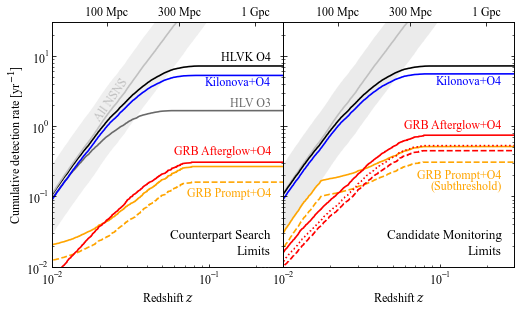

In [8]:
gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,2,gridspec_kw=gs_kw) 

###--- Counterpart search
ax[0].loglog(x,cum_gw_O4,c='black',linestyle='-',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_O3,c='dimgrey',linestyle='-',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_kn,c='blue',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_fermi,label='All Sky',c='orange',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_fermi*0.6,ls="--",label='Fermi/GBM',c='orange',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_grb,c='red',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
ax[0].fill_between(x[::10],cum_tot_high[::10],cum_tot_low[::10],color='silver',alpha=0.25,edgecolor="None",zorder=1)

ax[0].set_xlabel('Redshift $z$',size=12)
ax[0].set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax[0].set_ylim((0.01,30.))
ax[0].set_xlim((0.01,0.3))
ax[0].set_xticks([0.01,0.1])
ax[0].set_xticklabels(('0.01','0.1'),size=12)
ax[0].minorticks_on()
ax2 = ax[0].twiny()
ax2.set_xlim((0.01,0.3))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.0647,0.198])
ax2.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
ax[0].tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
ax2.tick_params(direction='in',which='both',zorder=2)
ax[0].yaxis.labelpad = 0.1
ax[0].set_yscale('log')
ax[0].set_xscale('log')

plt.text(0.25,8.5, "HLVK O4", ha='right', color="black",size=12.)
plt.text(0.25,1.9, "HLV O3", ha='right', color="dimgrey",size=12.)
plt.text(0.25,3.8, "Kilonova+O4", ha='right', color="blue",size=12.)
plt.text(0.25,0.1, "GRB Prompt+O4", ha='right', color="orange",size=12.)
plt.text(0.25,0.39, "GRB Afterglow+O4", ha='right', color="red",size=12.)
plt.text(0.018,1.2, "All NSNS", rotation = 55, color="silver",size=12.)
plt.text(0.25,0.025,"Counterpart Search",ha='right',size=13)
plt.text(0.25,0.015,"Limits",ha='right',size=13)

###--- Candidate monitoring
ax[1].loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_O4,c='black',linestyle='-',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_kn_mon,c='blue',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_fermi_mon*0.6,c='orange',ls="--",linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_fermi_mon,c='orange',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_radio_mon,label='Radio',c='red',ls='-',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_optic_mon,label='Optical',c='red',ls='--',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_x_mon,label='X',c='red',ls=':',linewidth=1.6,zorder=1)
ax[1].fill_between(x[::10],cum_tot_high[::10],cum_tot_low[::10],color='silver',alpha=0.3,edgecolor="None",zorder=1)

ax[1].set_xlabel('Redshift $z$',size=12)
ax[1].set_ylim((0.01,30.))
ax[1].set_xlim((0.01,0.3))
ax[1].set_xticks([0.01,0.1])
ax[1].set_xticklabels(('0.01','0.1'),size=12)
ax[1].tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=12,labelcolor="white",zorder=2)
ax[1].tick_params(axis = 'x',direction='in',which='both',labelsize=12)
ax3 = ax[1].twiny()
ax3.set_xlim((0.01,0.3))
ax3.set_xscale('log')
ax3.minorticks_off()
ax3.set_xticks([0.02225,0.0647,0.198])
ax3.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
fig1.subplots_adjust(wspace=0.,right=0.98)
ax3.tick_params(direction='in',which='both',zorder=2)
ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.text(0.25,3.9, "Kilonova+O4", ha='right', color="blue",size=12.)
plt.text(0.25,0.91, "GRB Afterglow+O4", ha='right', color="red",size=12.)
plt.text(0.25,0.18, "GRB Prompt+O4", ha='right', color="orange",size=12.)
plt.text(0.25,0.13, "(Subthreshold)", ha='right', color="orange",size=12.)
plt.text(0.25,0.025,"Candidate Monitoring",ha='right',size=13)
plt.text(0.25,0.015,"Limits",ha='right',size=13)

plt.show()

### Figure 2: kilonova

For the KN we will plot the lightcurves distribution for the O4-detectable binaries in the $g$ and $z$ bands. Then we will add the AT2017gfo data rescaled at the median distance of our population and also the cumulative distribution of the apparent AB magnitude at peak, at 3 and at 5 days after the merger.

In [11]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

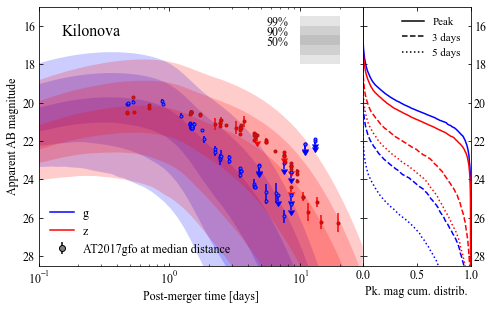

In [12]:
# transform absolute magnitudes to apparent
lc_kn_APP = np.zeros([num,len(kn_waves),len(t_kn)])

for i in range(len(kn_waves)):
    for j in range(len(t_kn)):
        lc_kn_APP[:,i,j] = abs_to_app(lc_kn[:,i,j],dL*1.e6)

mpk_g = np.min(lc_kn_APP[:,0], axis=1)
mpk_z = np.min(lc_kn_APP[:,1], axis=1)
mpk_J = np.min(lc_kn_APP[:,2], axis=1)

mpk_g_3 = np.min(lc_kn_APP[:,0,29:], axis=1)
mpk_z_3 = np.min(lc_kn_APP[:,1,29:], axis=1)
mpk_J_3 = np.min(lc_kn_APP[:,2,29:], axis=1)

mpk_g_5 = np.min(lc_kn_APP[:,0,34:], axis=1)
mpk_z_5 = np.min(lc_kn_APP[:,1,34:], axis=1)
mpk_J_5 = np.min(lc_kn_APP[:,2,34:], axis=1)


# construct confidence regions
perc = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

conf_curves_g=np.zeros([len(perc),len(t_kn)])
conf_curves_z=np.zeros([len(perc),len(t_kn)])
conf_curves_J=np.zeros([len(perc),len(t_kn)])

gw_det = gw_det_O4
for i in range(len(t_kn)):
    conf_curves_g[:,i]=corner.quantile(lc_kn_APP[:,0,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_z[:,i]=corner.quantile(lc_kn_APP[:,1,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_J[:,i]=corner.quantile(lc_kn_APP[:,2,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))

# plot confidence curves
kn_bands = ['g','z']
kn_colors = ['blue','red']

left=0.1
bottom=0.14
width=0.6
height=0.8
plt.axes([left,bottom,width,height])

for i,conf in enumerate([conf_curves_g,conf_curves_z]):
    plt.fill_between(t_kn,conf[0],conf[-1],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[1],conf[-2],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[2],conf[-3],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)

if True: # add AT2017gfo for comparison
    ## find median distance
    W = w*gw_det
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)
 
    mjd_gw = 57982.5285
    at2017gfo = pandas.read_csv('./AT2017gfo/At2017gfo_photometry.csv')
    dist_mod = 5*np.log10(dL_median/42.)
    zband = at2017gfo['band'].astype(str)=='z'
    gband = at2017gfo['band'].astype(str)=='g'
    Jband = at2017gfo['band'].astype(str)=='J'
    uplims = at2017gfo['upperlimit'].astype(str)=='T'
    at2017gfo['e_magnitude'][uplims]=-0.3
    extinction = {'g':0.4,'z':0.16,'J':0.087} # r: 0.28
    
    plt.errorbar(at2017gfo['time'][gband]-mjd_gw,at2017gfo['magnitude'][gband]+dist_mod-extinction['g'],yerr=at2017gfo['e_magnitude'][gband],markersize=3,markerfacecolor="royalblue",color='blue',ls='None',marker='o',uplims=uplims[gband])
    plt.errorbar(at2017gfo['time'][zband]-mjd_gw,at2017gfo['magnitude'][zband]+dist_mod-extinction['z'],yerr=at2017gfo['e_magnitude'][zband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[zband])    

plt.errorbar(100,100,yerr=1000,color='black',markerfacecolor="grey",ls='None',label='AT2017gfo at median distance',marker='o')
plt.plot([0.],[0.],color='blue',label='g')
plt.plot([0.],[0.],color='red',label='z')

plt.fill_between([1.e1,2.e1],[18.,18.],[15.5,15.5],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.5,17.5],[16.,16.],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.,17.],[16.5,16.5],color="grey",alpha=0.2,edgecolor=None)

plt.text(5.5,16.,"99%",size=12)
plt.text(5.5,16.5,"90%",size=12)
plt.text(5.5,17.,"50%",size=12)
plt.text(0.15,16.5,"Kilonova",size=16)

plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlim([1e-1,30.])
plt.ylim([28.5,15.])
plt.xlabel(r'Post-merger time [days]',size=12)
plt.ylabel(r'Apparent AB magnitude',size=12)
plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=12)
plt.legend(loc='lower left',frameon=False,prop={'size': 12})

# construct cumulative peak mag distribution
#np.histogram
s_mpk_g,bins_g,patches = plt.hist(mpk_g,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z,bins_z,patches = plt.hist(mpk_z,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g = np.zeros(len(bins_g)-1)
bincentre_z = np.zeros(len(bins_z)-1)
for j in range(len(bins_g)-1):
    bincentre_g[j] = bins_g[j] + (bins_g[j+1] - bins_g[j]) / 2.
    bincentre_z[j] = bins_z[j] + (bins_z[j+1] - bins_z[j]) / 2.
    
s_mpk_g_3,bins_g_3,patches = plt.hist(mpk_g_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_3,bins_z_3,patches = plt.hist(mpk_z_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_3 = np.zeros(len(bins_g_3)-1)
bincentre_z_3 = np.zeros(len(bins_z_3)-1)
for j in range(len(bins_g_3)-1):
    bincentre_g_3[j] = bins_g_3[j] + (bins_g_3[j+1] - bins_g_3[j]) / 2.
    bincentre_z_3[j] = bins_z_3[j] + (bins_z_3[j+1] - bins_z_3[j]) / 2.
    
s_mpk_g_5,bins_g_5,patches = plt.hist(mpk_g_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_5,bins_z_5,patches = plt.hist(mpk_z_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_5 = np.zeros(len(bins_g_5)-1)
bincentre_z_5 = np.zeros(len(bins_z_5)-1)
for j in range(len(bins_g_5)-1):
    bincentre_g_5[j] = bins_g_5[j] + (bins_g_5[j+1] - bins_g_5[j]) / 2.
    bincentre_z_5[j] = bins_z_5[j] + (bins_z_5[j+1] - bins_z_5[j]) / 2.

# plot cumulative distributions
plt.axes([left+width,bottom,1-left-width-0.1,height])
plt.plot(s_mpk_g,bincentre_g,color=kn_colors[0])
plt.plot(s_mpk_z,bincentre_z,color=kn_colors[1])

plt.plot(s_mpk_g_3,bincentre_g_3,color=kn_colors[0],ls="--")
plt.plot(s_mpk_z_3,bincentre_z_3,color=kn_colors[1],ls="--")

plt.plot(s_mpk_g_5,bincentre_g_5,color=kn_colors[0],ls=":")
plt.plot(s_mpk_z_5,bincentre_z_5,color=kn_colors[1],ls=":")

plt.axvline(10,c='black',ls='-',label='Peak')
plt.axvline(10,c='black',ls='--',label='3 days')
plt.axvline(10,c='black',ls=':',label='5 days')

plt.legend(frameon=False,prop={'size': 11})
plt.ylim([28.5,15.])
plt.xlim([0.,1.])
plt.tick_params(which='both',direction='in',labelleft=False,labelright=True,right=True,top=True,labelsize=12)
plt.xlabel('Pk. mag cum. distrib.',size=12)

plt.show()

### Figure 3: GRB afterglow

For the GRB afterglow we will plot a sample of 500 optical lightcurves from our population, then we will plot the peak flux distribution in the radio, optical and X band and also the observed data of GRB170817A at the median distance of our population. At the end we will also add the AB magnitude and the $\nu L_{\nu}$ axis.

In [13]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=5.5,3.9
plt.rcParams['mathtext.fontset']='dejavuserif'

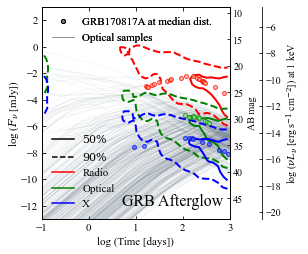

In [14]:
fig,ax1 = plt.subplots()

#Plotting lc samples        
random.seed(0)
ind = np.linspace(0,num-1,num,dtype="int")
ran = random.choices(ind,weights=w*(m_disk>0.)*(m_rem>1.2*mns_max)*gw_det_O4*(Ec>0)*(m_disk>1.e-4),k=500)

for i in range(0,len(ran)):
    ax1.plot(np.log10(t_grb),np.log10(lc_grb[ran[i],1,:]),c="slategray",linewidth=0.6,alpha=0.1,zorder=1)

#Plotting lc peak
color_grb = [['red','red'],['green','green'],['blue','blue']]
for i in range(0,len(grb_nu)):
    grb_peak_nu = grb_peak[:,i]
    t_peak = t_grb[np.argmax(lc_grb, axis=2)]
    t_peak_nu = t_peak[:,i]

    bins = 40
    H, xedges, yedges= np.histogram2d(np.log10(t_peak_nu[(m_rem>1.2*mns_max)*(Ec>0)*(m_disk>1.e-4)]),np.log10(grb_peak_nu[(m_rem>1.2*mns_max)*(Ec>0)*(m_disk>1.e-4)]),weights=(w*gw_det_O4)[(m_rem>1.2*mns_max)*(Ec>0)*(m_disk>1.e-4)],bins=bins)

    c = smoothing(H,1.0)
    
    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)

    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
    
    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

    T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax1.contour(T,M,c,levels=[0.1,0.5],colors=color_grb[i],linestyles=['--','-'],linewidths=2.,zorder=2)
    
ax1.set_xlabel(r'log (Time [days])',size=11)
ax1.set_ylabel(r'log ($F_\nu$ [mJy])',size=11,labelpad=0.1)
leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls='--'),Line2D([0],[0],color='red'),Line2D([0],[0],color='green'),Line2D([0],[0],color='blue')],[r'$50\%$',r'$90\%$','Radio','Optical','X'],loc=3,prop={'size': 11},frameon=False)
plt.gca().add_artist(leg1)
ax1.set_ylim((-13,3))
ax1.set_xlim((-1,3))

t_x,f_x,grb170817_x,errhigh_x,errlow_x=np.loadtxt("./GRB170817A/afterglow_x.txt", usecols=[0,1,2,3,4],unpack=True)
t_r,f_r,grb170817_r,err_r=np.loadtxt("./GRB170817A/afterglow_r.txt", usecols=[0,1,2,3],unpack=True)
t_o,f_o,grb170817_o,err_o=np.loadtxt("./GRB170817A/afterglow_o.txt", usecols=[0,1,2,3],unpack=True)

W = w*gw_det_O4
s = np.argsort(dL)
dL_cdf = np.cumsum(W[s])
dL_cdf/=dL_cdf[-1]
dL0 = np.sort(dL)
dL_median = np.interp(0.5,dL_cdf,dL0)

scale_dis = (dL_median**2)/(42**2)

after_x = grb170817_x*1.e-3/scale_dis
errhigh_after_x = errhigh_x*1.e-3/scale_dis
errlow_after_x = errlow_x*1.e-3/scale_dis
plt.errorbar(np.log10(t_x),np.log10(after_x),markersize=4,markerfacecolor="royalblue",color='blue',ls='None',marker='o',zorder=2,alpha=0.7)

after_o = grb170817_o*1.e-3/scale_dis
err_after_o = err_o*1.e-3/scale_dis
plt.errorbar(np.log10(t_o),np.log10(after_o),markersize=4,markerfacecolor="lightgreen",color='green',ls='None',marker='o',zorder=2,alpha=0.7)

after_r = grb170817_r*1.e-3/scale_dis
err_after_r = err_r*1.e-3/scale_dis
plt.errorbar(np.log10(t_r),np.log10(after_r),markersize=4,markerfacecolor="lightsalmon",color='red',ls='None',marker='o',zorder=2,alpha=0.7)

leg2=plt.legend([Line2D([0], [0], marker='o', ls="None", color='grey',markeredgecolor='black', markersize=4),Line2D([0],[0],color='slategray',lw=0.6)],[r'GRB170817A at median dist.',r'Optical samples'],loc=2,frameon=False,prop={'size': 11})
plt.gca().add_artist(leg2)

plt.text(0.7,-12,"GRB Afterglow",size=16)
plt.tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=11,zorder=7)

ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mJy_to_ABmag(10**(mn)), mJy_to_ABmag(10**(mx)))
ax2.set_ylabel('AB mag',size=10)
plt.tick_params(direction='in',right=True,labelsize=10,zorder=7)

ax3 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax3.set_ylim(np.log10(2.41e17 * 4.*np.pi * 1.e-26*(10**(mn))), np.log10(2.41e17 * 4.*np.pi * 1.e-26*(10**(mx))))
ax3.set_ylabel(r'log ($\nu L_\nu$ [erg s$^{-1}$ cm$^{-2}$]) at 1 keV',size=10)
ax3.spines["right"].set_position(("axes",1.17))
plt.tick_params(direction='in',right=True,labelsize=10,zorder=7)
plt.subplots_adjust(right=0.6)

plt.show()

### Figure 4: GRB prompt

For the GRB prompt we will plot the rest-frame SED peak photon energy $E_\mathrm{peak}$ versus the isotropic-equivalent energy $E_\mathrm{iso}$ for the GW O4-, Fermi- and GW O4+Fermi-detectable binaries. Then we will add a sample of SGRBs with known redshift.

In [15]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=4.5,3.8
plt.rcParams['mathtext.fontset']='dejavuserif'

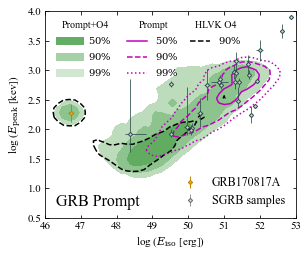

In [16]:
#######-------- GW
bins = 50
smooth = 0.85

H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),np.log10(Epeak_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),weights=(w*gw_det_O4)[(m_disk>0.)*(m_rem>1.2*mns_max)],bins=bins,range=[[45.,53.],[0.,4.]])

c = smoothing(H,smooth)

xcentre = np.zeros(bins)
ycentre = np.zeros(bins)

for j in range(len(xedges)-1):
    xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

for j in range(len(yedges)-1):
    ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')

plt.contour(X,Y,c,levels=[0.1,1.],colors="black",linestyles="--",linewidths=1.5)

#######-------- FERMI
H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),np.log10(Epeak_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),weights=(w*prompt_det_fermi)[(m_disk>0.)*(m_rem>1.2*mns_max)],bins=bins,range=[[45.,53.],[0.,4.]])

c = smoothing(H,smooth)

xcentre = np.zeros(bins)
ycentre = np.zeros(bins)

for j in range(len(xedges)-1):
    xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

for j in range(len(yedges)-1):
    ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(X,Y,c,levels=[0.01,0.1,0.5],colors="m",linestyles=[':','--','-'],linewidths=1.5)

#######-------- GW + FERMI
H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),np.log10(Epeak_tot[(m_disk>0.)*(m_rem>1.2*mns_max)]),weights=(w*prompt_det_fermi*gw_det_O4)[(m_disk>0.)*(m_rem>1.2*mns_max)],bins=bins,range=[[45.,53.],[0.,4.]])

c = smoothing(H,smooth)

xcentre = np.zeros(bins)
ycentre = np.zeros(bins)

for j in range(len(xedges)-1):
    xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

for j in range(len(yedges)-1):
    ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contourf(X,Y,c,levels=[0.01,1.],colors="forestgreen",alpha=.3)
plt.contourf(X,Y,c,levels=[0.1,1.],colors="forestgreen",alpha=.3)
plt.contourf(X,Y,c,levels=[0.5,1.],colors="forestgreen",alpha=.4)

#######-------- SGRB DATA
data = pandas.read_csv('./GRBs/GRB_table.dat',delim_whitespace=True)

Ep_data = data["Ep"]
Ep_err_high = data["Ep_err_high"]
Ep_err_low = data["Ep_err_low"]

Eiso_data = data["Eiso_51"]*1.e51
Eiso_err_high = data["Eiso_51_err_high"]*1.e51
Eiso_err_low = data["Eiso_51_err_low"]*1.e51

yerr = (np.log10(1.+(Ep_err_low/Ep_data)),np.log10(1.+(Ep_err_high/Ep_data)))
xerr = (np.log10(1.+(Eiso_err_low/Eiso_data)),np.log10(1.+(Eiso_err_high/Eiso_data)))
plt.errorbar(np.log10(Eiso_data),np.log10(Ep_data),xerr=xerr,yerr=yerr,marker='D',linestyle='None',color="darkslategrey",elinewidth=0.8,markersize=3.,markerfacecolor="lightgrey",alpha=0.99,zorder=3)

Eiso_grb170817a = 5.3e46 #erg
Eiso_err_grb170817a = 1.e46 #erg
Epeak_grb170817a = 185 #kev
Epeak_err_grb170817a = 78 #kev
plt.errorbar(np.log10(Eiso_grb170817a),np.log10(Epeak_grb170817a),xerr=np.log10(1.+(Eiso_err_grb170817a/Eiso_grb170817a)),yerr=np.log10(1.+(Epeak_err_grb170817a/Epeak_grb170817a)),marker='D',linestyle='None',color='darkgoldenrod',markerfacecolor="orange",elinewidth=1.,markersize=3.,zorder=3)

plt.xlabel(r'log ($E_\mathrm{iso}$ [erg])',size=11)
plt.ylabel(r'log ($E_\mathrm{peak}$ [kev])',size=11)

plt.tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)

leg1=plt.legend([Line2D([0],[0],color='forestgreen',lw=8,alpha=0.7),Line2D([0],[0],color="forestgreen",lw=8,alpha=0.4),Line2D([0],[0],color='forestgreen',lw=8,alpha=0.2)],[r'$50\%$',r'$90\%$',r'$99\%$'],bbox_to_anchor=(0.3, 0.999),title="Prompt+O4",title_fontsize=10,prop={'size': 10},frameon=False)
leg2=plt.legend([Line2D([0],[0],color='m'),Line2D([0],[0],color='m',ls="--"),Line2D([0],[0],color='m',ls=":")],[r'$50\%$',r'$90\%$',r'$99\%$'],bbox_to_anchor=(0.57, 0.999),title="Prompt",title_fontsize=10,prop={'size': 10},frameon=False)
leg3=plt.legend([Line2D([0],[0],color='black',ls="--")],[r'$90\%$'],bbox_to_anchor=(0.82, 0.999),title="HLVK O4",title_fontsize=10,prop={'size': 10},frameon=False)
plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)
plt.gca().add_artist(leg3)

plt.errorbar(100,100,yerr=1000,marker='D',linestyle='None',color='darkgoldenrod',markerfacecolor='orange',elinewidth=1.,markersize=3.,label="GRB170817A")
plt.errorbar(100,100,yerr=1000,marker='D',linestyle='None',color="dimgrey",elinewidth=0.7,markersize=3.,markerfacecolor="lightgrey",alpha=0.99,label="SGRB samples")
plt.legend(loc=4,prop={'size': 12},frameon=False)

plt.text(46.3,0.7,"GRB Prompt",size=16)

plt.xlim(46.,53.)
plt.ylim(0.5,4.)
plt.show()